In [1]:
import pandas as pd 
from pandas import DataFrame
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

In [2]:
## Data Cleaning & Preparation

In [3]:
df = pd.read_csv("NCAA_Tourney_2002_2019_update.csv")

In [5]:
df_clean = df.copy()

In [6]:
df_clean.head(3)

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,...,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id
0,1192.0,82,1341.0,76,N,0,X16a,X16b,16,16,...,106.296,104.7090,110.550,72.5879,71.0282,103.120,101.6550,99.7542,105.959,2019-1192.0-1341.0
1,1125.0,81,1396.0,70,N,0,W11a,W11b,11,11,...,114.952,99.6691,101.886,70.1158,68.8256,105.306,108.9910,100.1860,99.563,2019-1125.0-1396.0
2,1295.0,78,1300.0,74,N,0,W16a,W16b,16,16,...,106.675,110.0540,109.873,67.1363,65.2686,100.502,96.7551,100.7490,108.661,2019-1295.0-1300.0


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

df_cut = df[[ "team1_teamname", "team1_score", "team2_teamname","team2_score"]]
df_cut["team1_spead"] = df_cut["team1_score"] - df_cut["team2_score"]
df_cut["team2_spead"] = -df_cut["team1_spead"]

df_cut.tail()

teams = pd.concat([
    df_cut[['team1_teamname', 'team1_spead','team2_teamname']].rename(columns={'team1_teamname': 'team', 'team1_spead': 'spread', 'team2_teamname': 'opponent'}),
    df_cut[['team2_teamname', 'team2_spead','team1_teamname']].rename(columns={'team2_teamname': 'team', 'team2_spead': 'spread', 'team1_teamname': 'opponent'})
])
teams.tail()

import numpy as np

teams['spread'] = np.where(teams['spread'] > 15, 15, teams['spread'])
teams['spread'] = np.where(teams['spread'] < -15, -15, teams['spread'])

spreads = teams.groupby('team').spread.mean()
spreads

terms = []
solutions = []

for team in spreads.keys():
    row = []
    # get a list of team opponents
    opps = list(teams[teams['team'] == team]['opponent'])
    
    for opp in spreads.keys():
        if opp == team:
        	# coefficient for the team should be 1
            row.append(1)
        elif opp in opps:
        	# coefficient for opponents should be 1 over the number of opponents
            row.append(-1.0/len(opps))
        else:
        	# teams not faced get a coefficient of 0
            row.append(0)
            
    terms.append(row)
    
    # average game spread on the other side of the equation
    solutions.append(spreads[team])

solutions = np.linalg.solve(np.array(terms), np.array(solutions))

ratings = list(zip( spreads.keys(), solutions ))
srs = pd.DataFrame(ratings, columns=['team', 'rating'])
srs.head()

rankings = srs.sort_values('rating', ascending=False).reset_index()[['team', 'rating']]
rankings.loc[:10]

team_list = list(rankings['team']) 
rating_list = list(rankings['rating'])

team1_rating = []
team1_namelist = list(df['team1_teamname'])

for i in team1_namelist:
  unique_index = pd.Index(team_list)
  team_index = unique_index.get_loc(i)
  team_rating = rating_list[team_index]
  team1_rating.append(team_rating)

team2_rating = []
team2_namelist = list(df['team2_teamname'])

for i in team2_namelist:
  unique_index = pd.Index(team_list)
  team_index = unique_index.get_loc(i)
  team_rating = rating_list[team_index]
  team2_rating.append(team_rating)

rating_diff = []
for i in range(len(team1_rating)):
  game_rating_diff = team1_rating[i] - team2_rating[i]
  rating_diff.append(game_rating_diff)
  

rating_compare = []
for i in rating_diff:
  if i > 2:
    rating_compare.append(1)
  elif i < -2:
    rating_compare.append(-1)
  else:
    rating_compare.append(0)

df['rating_diff'] = rating_compare

df['rating_diff'].value_counts()



def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

df['dist1'] = df.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
df['dist2'] = df.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

df['diff_dist'] = df['dist1'] - df['dist2']


df['exp_win1'] = (df['team1_adjoe']**11.5)/ ((df['team1_adjde']**11.5)+(df['team1_adjoe']**11.5))
df['exp_win2'] = (df['team2_adjoe']**11.5)/ ((df['team2_adjde']**11.5)+(df['team2_adjoe']**11.5))



#Log 5 is a formula invented by Bill James[1] to estimate the probability that team A will win a game, based on the true winning percentage of Team A and Team B.

df['team1_log5'] = (df['exp_win1'] - (df['exp_win1']*df['exp_win2']))/ (df['exp_win1']+df['exp_win2']-(2*df['exp_win1']*df['exp_win2']))

seed_diff = list(df['team1_seed'] - df['team2_seed'])

seed_compare = []
for i in seed_diff:
  if i >= 4:
    seed_compare.append(1)
  elif i <= -4:
    seed_compare.append(-1)
  else:
    seed_compare.append(0)

df['seed_diff'] = seed_compare

df['seed_diff'].value_counts()

df['team1_win'] = (df['team1_score']>df['team2_score']).astype(int)

def tran(x):
  if x != 0:
    return 1
  else: 
    return 0


df['team1_ff'] = df['team1_pt_overall_ff'].apply(tran)
df['team2_ff'] = df['team2_pt_overall_ff'].apply(tran)
df['ff_diff'] = df['team1_ff'] - df['team2_ff']

df['ff_diff'].value_counts()

np.random.seed(0)

def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)
random_indices = random.sample(range(len(df)), int(len(df)/2))

df_1 = df[~df.index.isin(random_indices)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score', 'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff', 'ff_diff','rating_diff']].reset_index(drop=True)
df_2 = df[df.index.isin(random_indices)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff', 'ff_diff','rating_diff']].reset_index(drop=True)

df_2['team1_win'] = df['team1_win'].apply(lambda x: 1 if x==0 else 0)
df_2['diff_dist'] = df['diff_dist']*-1
df_2['ff_diff'] = df['ff_diff']*-1
df_2['seed_diff'] = df['seed_diff']*-1
df_2['rating_diff'] = df['rating_diff']*-1
df_2['team1_log5'] = (df['exp_win2'] - (df['exp_win1']*df['exp_win2']))/ (df['exp_win1']+df['exp_win2']-(2*df['exp_win1']*df['exp_win2']))
df_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff', 'ff_diff','rating_diff']



df_2['team1_win'].value_counts()

df_1['team1_win'].value_counts()

mm_train = pd.concat([df_2, df_1])

mm_data_2019 = mm_train[mm_train['season'] == 2019].reset_index(drop=True)
mm_data_else = mm_train[mm_train['season'] != 2019].reset_index(drop=True)

/Users/wangyue/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/wangyue/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wangyue/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the 

In [12]:
y_test = mm_data_2019['team1_win']
x_test = mm_data_2019[['ff_diff','seed_diff','diff_dist','team1_log5','rating_diff']]
y_train = mm_data_else['team1_win']
x_train = mm_data_else[['ff_diff','seed_diff','diff_dist','team1_log5','rating_diff']]

In [16]:
y = y_train
X = x_train

In [13]:
def summary_tree(model_object):
  dot_data = StringIO()
  export_graphviz(model_object, out_file=dot_data, filled=True,
                  rounded=True, special_characters=True, feature_names=X.columns.values,
                  class_names=['0', '1'])
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  output_imagefile = 'tree.png'
  graph.write_png(output_imagefile)
  return output_imagefile

In [14]:
# Depth level of the Classification Tree
kfolds = 5
maximum_depth = 100
minimum_depth = 1

param_grid = {'max_depth':list(range(minimum_depth, maximum_depth+1))}

In [17]:
gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_BPT = gridsearch.best_estimator_

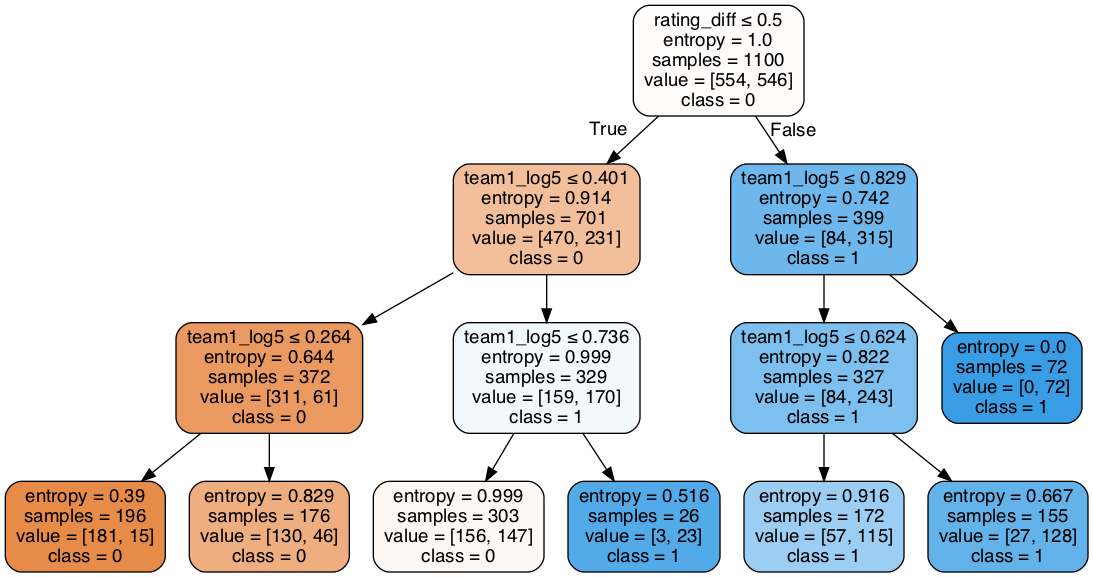

In [18]:
Image(summary_tree(clf_BPT))

In [19]:
print(clf_BPT.get_depth())

3


In [20]:
y_test_actual = mm_data_2019['team1_win']
X_test = mm_data_2019[['ff_diff','seed_diff','diff_dist','team1_log5','rating_diff']]

In [21]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test_actual, clf_BPT.predict_proba(X_test)[:,1]))

0.8316696914700545


In [24]:
predict_proba = clf_BPT.predict_proba(X_test)
log_loss(y_test, predict_proba)

0.4837211775982048

In [22]:
def get_treepaths(dtc, df):
    rules_list = []
    values_path = []
    values = dtc.tree_.value

    def RevTraverseTree(tree, node, rules, pathValues):
        try:
            prevnode = tree[2].index(node)           
            leftright = '<='
            pathValues.append(values[prevnode])
        except ValueError:
            # failed, so find it as a right node - if this also causes an exception, something's really f'd up
            prevnode = tree[3].index(node)
            leftright = '>'
            pathValues.append(values[prevnode])

        # now let's get the rule that caused prevnode to -> node
        p1 = df.columns[tree[0][prevnode]]    
        p2 = tree[1][prevnode]    
        rules.append(str(p1) + ' ' + leftright + ' ' + str(p2))

        # if we've not yet reached the top, go up the tree one more step
        if prevnode != 0:
            RevTraverseTree(tree, prevnode, rules, pathValues)

    # get the nodes which are leaves
    leaves = dtc.tree_.children_left == -1
    leaves = np.arange(0,dtc.tree_.node_count)[leaves]

    # build a simpler tree as a nested list: [split feature, split threshold, left node, right node]
    thistree = [dtc.tree_.feature.tolist()]
    thistree.append(dtc.tree_.threshold.tolist())
    thistree.append(dtc.tree_.children_left.tolist())
    thistree.append(dtc.tree_.children_right.tolist())

    # get the decision rules for each leaf node & apply them
    for (ind,nod) in enumerate(leaves):

        # get the decision rules
        rules = []
        pathValues = []
        RevTraverseTree(thistree, nod, rules, pathValues)

        pathValues.insert(0, values[nod])      
        pathValues = list(reversed(pathValues))

        rules = list(reversed(rules))

        rules_list.append(rules)
        values_path.append(pathValues)

    for i in range(len(rules_list)):
      
      print('\nLeaf node ID =', i+1)
      print('Path =', rules_list[i])
      distro = sum(values_path[i][-1])
      print('sample =', int(sum(distro)))
      print('value =', list([int(distro[0]), int(distro[1])]))
      predicted_class = 1 if distro[1] > distro[0] else 0
      print('class = ', predicted_class)
      
    return None

get_treepaths(dtc=clf_BPT, df= mm_data_2019)


Leaf node ID = 1
Path = ['game_id <= 0.5', 'ff_diff <= 0.4005928784608841', 'ff_diff <= 0.26390787959098816']
sample = 196
value = [181, 15]
class =  0

Leaf node ID = 2
Path = ['game_id <= 0.5', 'ff_diff <= 0.4005928784608841', 'ff_diff > 0.26390787959098816']
sample = 176
value = [130, 46]
class =  0

Leaf node ID = 3
Path = ['game_id <= 0.5', 'ff_diff > 0.4005928784608841', 'ff_diff <= 0.7359472513198853']
sample = 303
value = [156, 147]
class =  0

Leaf node ID = 4
Path = ['game_id <= 0.5', 'ff_diff > 0.4005928784608841', 'ff_diff > 0.7359472513198853']
sample = 26
value = [3, 23]
class =  1

Leaf node ID = 5
Path = ['game_id > 0.5', 'ff_diff <= 0.8292267620563507', 'ff_diff <= 0.624433696269989']
sample = 172
value = [57, 115]
class =  1

Leaf node ID = 6
Path = ['game_id > 0.5', 'ff_diff <= 0.8292267620563507', 'ff_diff > 0.624433696269989']
sample = 155
value = [27, 128]
class =  1

Leaf node ID = 7
Path = ['game_id > 0.5', 'ff_diff > 0.8292267620563507']
sample = 72
value = [0